# Tarea 3 Ejercicio 1 - Introducción a las Redes Neuronales y Deep Learning

**Nombre:** Bruno Morici

**ROL USM:** 202373555-8

**Curso:** INF395, Introducción a las Redes Neuronales y Deep Learning

**Profesor:** Alejandro Veloz

**Fecha:** 9/11/2025

# CNN Reimplementada en Pytorch
* Para este ejemplo reimplementaré el entrenamiento que había hecho con FANN de el dataset MNIST pero con CNN.
* Se utilizará una arquitectura según se muestra en el siguiente esquema:

In [ ]:
import numpy as np # Operaciones matematicas y arreglos numericos complejos
import pandas as pd # Usa DataFrames para procesar Datasets de mejor manera
import matplotlib.pyplot as plt # Visualizacion de graficos

import torch # Libreria base de PyTorch que sirve para crear y entrenar modelos con Tensores
from torch import optim # Optimiza los modelos ajustando pesos, aca usamos su funcion Adam
from torch import nn # Modulo de Neuronal Network: Permite definir capas de redes neuronales: ReLU, Linear, Pooling
from torch.utils.data import DataLoader # Carga datos en lotes (batches) y los mezcla durante el entrenamiento para disminuir sesgo
from tqdm import tqdm # Barra de progreso visual

import torchvision # Herramientas para Datasets, modelos preentrenados, y transformaciones de imagenes

import torch.nn.functional as F # Contiene funciones matematicas: relu, sigmoid, cross_entropy
import torchvision.datasets as datasets # Contiene datasets listos para entrenar (MNIST)
import torchvision.transforms as transforms # Permite transformar imagenes a tensores

from torchmetrics.classification import Accuracy, Precision, Recall # Metricas listas para usar despues del entrenamiento

In [2]:
# Definimos tamaño del lote de carga
batch_size = 60

# Descargamos el dataset de training y lo transformamos en un DataLoader
train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Descargamos el dataset de testing y lo transformamos en un DataLoader
test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 7.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 249kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 757kB/s]


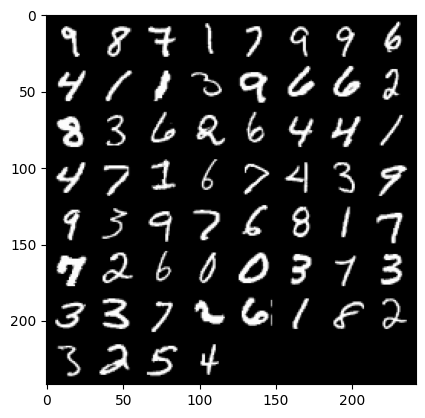

In [ ]:
def imshow(img):
   npimg = img.numpy() # Convertimos el Tensor en un array numpy
   plt.imshow(np.transpose(npimg, (1, 2, 0))) # Cambiamos las dimensiones ya que PyTorch entrega 3
   plt.show()

# Obtenemos datos de muestra (primer lote)
dataiter = iter(train_loader) 
images, _ = next(dataiter)

# make_grid combina todas las imagenes y hace un grid grande para mostrarlas todas
# Mostramos las imagenes
imshow(torchvision.utils.make_grid(images))

Creación del modelo CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, canales_entrada, n_clases):
        """
        Parametros:
            canales_entrada: Numero de canales de entrada de la imagen (RGB: 3, Gris: 1, RGBA: 4)
            n_clases: Numero de clases de la clasificacion, en este caso 10
        """
        super(CNN, self).__init__()
        
        """
        Sobre nn.CAPA:
            in_channels: Aclaramos los canales que se ingresaran
            kernel_size: Tamaño del filtro de la convolucion
            padding: Le agregamos padding de 1, así podemos aplicar convolución a los bordes de las imagenes
            out_channels=8: Numero de features map que creara
        """
        # Primera capa convolucional
        self.conv1 = nn.Conv2d(in_channels=canales_entrada, out_channels=8, kernel_size=3, padding=1)

        # Capa Max Pooling para reducir dimensionalidad
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
        # Segunda Capa Convolucional
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)

        # Capa Fully Connected, donde la salida es el numero de clases
        ### 16*7*7 = Canales*Alto*Ancho
        self.fc1 = nn.Linear(16 * 7 * 7, n_clases)

    def forward(self, x):
        """
        Parametros:
            x: Tensor

        Retorna:
            torch.Tensor: El tensor de salida luego de pasar por la red CNN
        """
        x = F.relu(self.conv1(x)) # Aplicamos primera convolucion y ReLU
        x = self.pool(x) # Aplicamos Max Pooling
        x = F.relu(self.conv2(x)) # Aplicamos segunda convolucion y ReLU
        x = self.pool(x) # Aplicamos Max Pooling (Se reduce a 7x7)
        x = x.reshape(x.shape[0], -1) # Aplanamos el tensor
        x = self.fc1(x) # Aplicamos capa Fully Connected
        return x


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Creamos el modelo
model = CNN(in_channels=1, num_classes=10).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [ ]:
# Definimos la funcion de perdida
criterion = nn.CrossEntropyLoss()

# Definimos el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

Entrenamiento de la CNN

In [ ]:
num_epochs=10
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    # Iteramos por sobre los DataLoader de entrenamiento
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)): # Ocupamos tqdm para ver el avance graficamente
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch [1/10]


100%|██████████| 1000/1000 [00:25<00:00, 38.92it/s]


Epoch [2/10]


100%|██████████| 1000/1000 [00:24<00:00, 40.22it/s]


Epoch [3/10]


100%|██████████| 1000/1000 [00:26<00:00, 37.81it/s]


Epoch [4/10]


100%|██████████| 1000/1000 [00:30<00:00, 32.33it/s]


Epoch [5/10]


100%|██████████| 1000/1000 [00:27<00:00, 36.09it/s]


Epoch [6/10]


100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]


Epoch [7/10]


100%|██████████| 1000/1000 [00:28<00:00, 35.54it/s]


Epoch [8/10]


100%|██████████| 1000/1000 [00:27<00:00, 36.59it/s]


Epoch [9/10]


100%|██████████| 1000/1000 [00:27<00:00, 36.36it/s]


Epoch [10/10]


100%|██████████| 1000/1000 [00:26<00:00, 38.05it/s]


Con torchmetrics verificamos el Accuracy, Precision y Recall del modelo entrenado

In [16]:
acc = Accuracy(task="multiclass", num_classes=10)
precision = Precision(task="multiclass", num_classes=10, average="macro")
recall = Recall(task="multiclass", num_classes=10, average="macro")

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        acc.update(preds, labels)
        precision.update(preds, labels)
        recall.update(preds, labels)
        
print(f"Accuracy:  {acc.compute():.4f}")
print(f"Precision: {precision.compute():.4f}")
print(f"Recall:    {recall.compute():.4f}")

Accuracy:  0.9913
Precision: 0.9913
Recall:    0.9912


# Resultados

| Métrica | Valor obtenido | Rendimiento (%) |
| :--- | :--- | :--- |
| **Accuracy** | **0.9913** | **99.13%** |
| **Precision** | **0.9913** | **99.13%** |
| **Recall** | **0.9912** | **99.12%** |

---

## Contraste con la Feed Fordward (Tarea 1 - Pregunta 3)

Se aplicó un entrenamiento del mismo dataset MNIST donde se utilizó una red feed forward hecha desde scratch y se obtuvieron los siguientes resultados:

| Modelo | Métrica | Valor obtenido | Rendimiento (%) |
| :--- | :--- | :--- | :--- |
| **CNN** | Accuracy | **0.9913** | **99.13%** |
| **FFN (from scratch)** | Accuracy | 0.95678 | 95.68% |

---

### 3. Conclusión sobre la Eficacia de la CNN

#### Observaciones Clave

* **Superioridad Clara:** La CNN demostró una **precisión significativamente mayor** ($99.13\%$) en comparación con la FFN ($95.68\%$), una diferencia de aproximadamente **3.45 puntos porcentuales**.
* **Confiabilidad:** Las métricas de Precision y Recall extremadamente altas (ambas $\approx 0.991$) confirman que la CNN no solo es precisa en general, sino también altamente confiable en sus predicciones.

#### La Razón de la Ventaja

La CNN supera a la FFN en el reconocimiento de imágenes porque:
1.  **Preserva la Estructura Espacial:** Las capas convolucionales aprenden patrones locales (bordes, curvas) sin perder la **conexión espacial** entre los píxeles.
2.  **La FFN Pierde Contexto:** La FFN requiere aplanar la imagen (convertir $28 \times 28$ a un vector de 784), **destruyendo la información** de cómo se relacionan los píxeles vecinos, lo cual es fundamental para identificar dígitos.

**En resumen, la arquitectura CNN es fundamentalmente superior para tareas visuales, ya que su diseño está optimizado para capturar las características jerárquicas y la estructura espacial que definen los dígitos de MNIST.**